<a href="https://colab.research.google.com/github/moon2su/ML-programming/blob/main/BP_PPG_%2B_ECG_CNN_2patient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [ ]:
mat_path_A = "/content/drive/MyDrive/Colab Notebooks/BP/p087608.mat"
mat_path_B = "/content/drive/MyDrive/Colab Notebooks/BP/p001587(test).mat"

In [ ]:
def load_signals_from_mat(mat_path, num_samples = 5):
  """- parameters
  mat_path : .mat 파일 경로
  num_samples : 로드할 샘플 갯수"""

  # PPG(광용적 맥파), ABP(혈압 파형), ECG(심전도), SBP(수축기 혈압), DBP(이완기 혈압)
  signals = {'ppg': [], 'abp': [], 'ecg': [], 'sbp': [], 'dbp': []}

  with h5py.File(mat_path, 'r') as f:
    #데이터 참조 가져오기
    ppg_refs = f['Subj_Wins']['PPG_F'][0]
    abp_refs = f['Subj_Wins']['ABP_F'][0] if 'ABP_F' in f['Subj_Wins'] else None
    ecg_refs = f['Subj_Wins']['ECG_F'][0] if 'ECG_F' in f['Subj_Wins'] else None
    sbp_refs = f['Subj_Wins']['SegSBP'][0]
    dbp_refs = f['Subj_Wins']['SegDBP'][0]

    #지정된 개수만큼 로드
    total = min(len(ppg_refs), num_samples)

    for i in range(total):
      #PPG Signal
      ppg = f[ppg_refs[i]][()].squeeze().astype(np.float32)
      signals['ppg'].append(ppg)

      #ABP Signal (있는 경우)
      if abp_refs is not None:
        abp = f[abp_refs[i]][()].squeeze().astype(np.float32)
        signals['abp'].append(abp)

      #ECG Signal (있는 경우)
      if ecg_refs is not None:
        ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
        signals['ecg'].append(ecg)

      # 혈압 타겟
      sbp = float(f[sbp_refs[i]][()][0][0])
      dbp = float(f[dbp_refs[i]][()][0][0])
      signals['sbp'].append(sbp)
      signals['dbp'].append(dbp)

  return signals

총 2000개의 세그먼트 로드 중...

=== 혈압 데이터 통계 ===
세그먼트 수: 2000

SBP (수축기 혈압):
  - 평균: 131.20 mmHg
  - 최소: 88.19 mmHg
  - 최대: 180.87 mmHg
  - 표준편차: 21.24 mmHg

DBP (이완기 혈압):
  - 평균: 59.02 mmHg
  - 최소: 42.81 mmHg
  - 최대: 82.25 mmHg
  - 표준편차: 8.79 mmHg


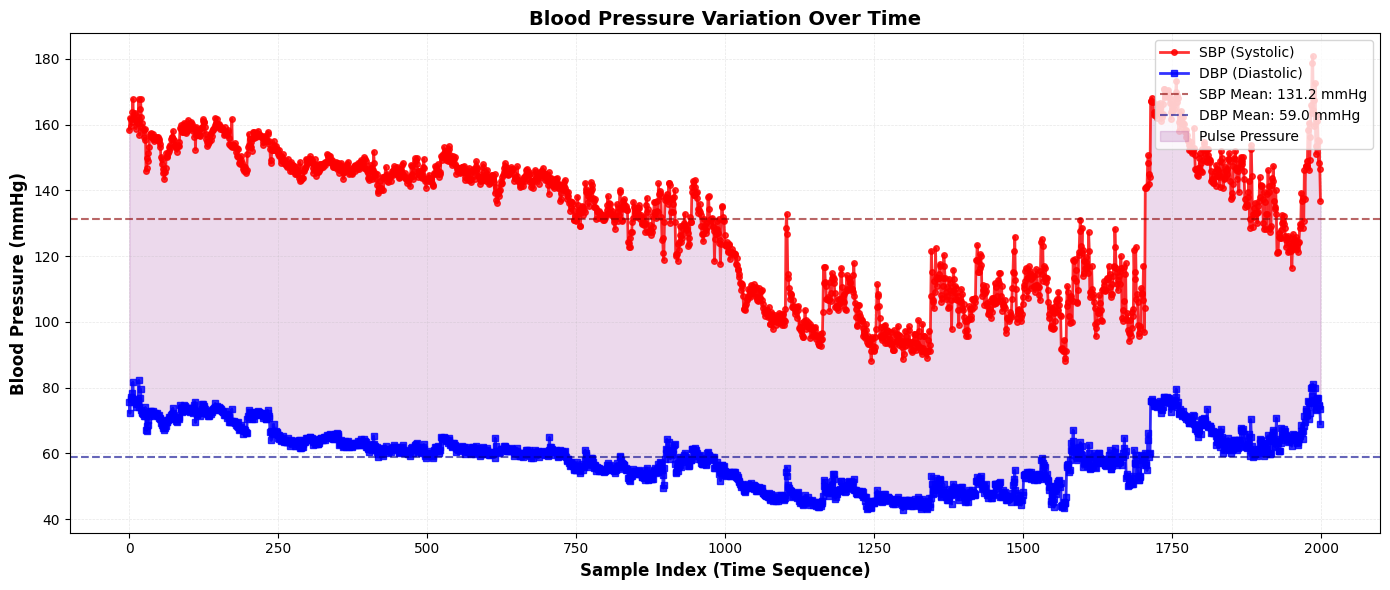

총 2000개의 세그먼트 로드 중...

=== 혈압 데이터 통계 ===
세그먼트 수: 2000

SBP (수축기 혈압):
  - 평균: 112.29 mmHg
  - 최소: 64.82 mmHg
  - 최대: 163.31 mmHg
  - 표준편차: 18.85 mmHg

DBP (이완기 혈압):
  - 평균: 59.44 mmHg
  - 최소: 31.78 mmHg
  - 최대: 102.50 mmHg
  - 표준편차: 13.47 mmHg


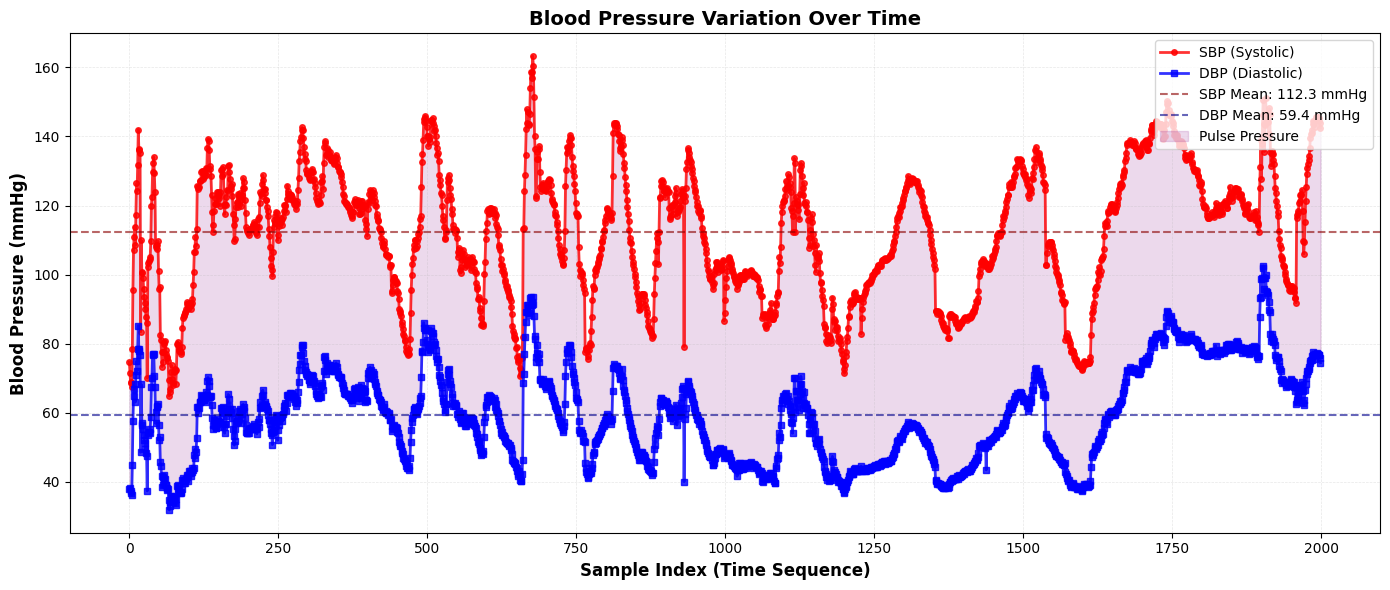

In [ ]:
def load_and_display_bp(mat_path, segment_limit=None):
    """
    MAT 파일에서 PPG 세그먼트와 혈압(SBP, DBP) 데이터를 로드하고 표시

    Args:
        mat_path: .mat 파일 경로
        segment_limit: 로드할 최대 세그먼트 수 (None이면 전체)
    """
    segments, sbp_list, dbp_list = [], [], []

    # MAT 파일 로드
    with h5py.File(mat_path, 'r') as f:
        refs = f['Subj_Wins']['PPG_F'][0]
        sbps = f['Subj_Wins']['SegSBP'][0]
        dbps = f['Subj_Wins']['SegDBP'][0]

        total = min(len(refs), segment_limit) if segment_limit else len(refs)

        print(f"총 {total}개의 세그먼트 로드 중...")

        for i in range(total):
            ppg = f[refs[i]][()].squeeze().astype(np.float32)
            sbp = float(f[sbps[i]][()][0][0])
            dbp = float(f[dbps[i]][()][0][0])

            segments.append(ppg)
            sbp_list.append(sbp)
            dbp_list.append(dbp)

    # 통계 출력
    print(f"\n=== 혈압 데이터 통계 ===")
    print(f"세그먼트 수: {len(segments)}")
    print(f"\nSBP (수축기 혈압):")
    print(f"  - 평균: {np.mean(sbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(sbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(sbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(sbp_list):.2f} mmHg")

    print(f"\nDBP (이완기 혈압):")
    print(f"  - 평균: {np.mean(dbp_list):.2f} mmHg")
    print(f"  - 최소: {np.min(dbp_list):.2f} mmHg")
    print(f"  - 최대: {np.max(dbp_list):.2f} mmHg")
    print(f"  - 표준편차: {np.std(dbp_list):.2f} mmHg")

    # 시각화
    plot_bp_combined_timeseries(sbp_list, dbp_list)

    return segments, sbp_list, dbp_list


def plot_bp_distribution(sbp_list, dbp_list):
    """혈압 분포 히스토그램"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.hist(sbp_list, bins=30, color='red', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('SBP (mmHg)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('SBP Distribution')
    ax1.axvline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.hist(dbp_list, bins=30, color='blue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('DBP (mmHg)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('DBP Distribution')
    ax2.axvline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_scatter(sbp_list, dbp_list):
    """SBP vs DBP 산점도"""
    plt.figure(figsize=(8, 6))
    plt.scatter(sbp_list, dbp_list, alpha=0.6, s=50, c=range(len(sbp_list)),
                cmap='viridis', edgecolors='black', linewidth=0.5)

    plt.xlabel('SBP (mmHg)', fontsize=12)
    plt.ylabel('DBP (mmHg)', fontsize=12)
    plt.title('SBP vs DBP Relationship', fontsize=14)
    plt.colorbar(label='Sample Index')
    plt.grid(alpha=0.3)

    # 추세선
    z = np.polyfit(sbp_list, dbp_list, 1)
    p = np.poly1d(z)
    plt.plot(sorted(sbp_list), p(sorted(sbp_list)), "r--",
             linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_bp_timeseries(sbp_list, dbp_list):
    """시간 순서에 따른 SBP/DBP 변화 그래프"""
    time_idx = np.arange(len(sbp_list))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # SBP 시계열
    ax1.plot(time_idx, sbp_list, color='red', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='SBP')
    ax1.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(sbp_list):.1f}')
    ax1.fill_between(time_idx, sbp_list, alpha=0.2, color='red')
    ax1.set_ylabel('SBP (mmHg)', fontsize=12, fontweight='bold')
    ax1.set_title('Systolic Blood Pressure Over Time', fontsize=14)
    ax1.legend(loc='upper right')
    ax1.grid(alpha=0.3)

    # DBP 시계열
    ax2.plot(time_idx, dbp_list, color='blue', linewidth=1.5,
             marker='o', markersize=3, alpha=0.7, label='DBP')
    ax2.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(dbp_list):.1f}')
    ax2.fill_between(time_idx, dbp_list, alpha=0.2, color='blue')
    ax2.set_xlabel('Sample Index (Time Sequence)', fontsize=12)
    ax2.set_ylabel('DBP (mmHg)', fontsize=12, fontweight='bold')
    ax2.set_title('Diastolic Blood Pressure Over Time', fontsize=14)
    ax2.legend(loc='upper right')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_bp_combined_timeseries(sbp_list, dbp_list):
    """SBP와 DBP를 하나의 그래프에 표시 (흰색 배경)"""
    time_idx = np.arange(len(sbp_list))

    fig = plt.figure(figsize=(14, 6), facecolor='white')
    ax = fig.add_subplot(111, facecolor='white')

    # SBP와 DBP 라인 플롯
    ax.plot(time_idx, sbp_list, color='red', linewidth=2,
            marker='o', markersize=4, alpha=0.8, label='SBP (Systolic)')
    ax.plot(time_idx, dbp_list, color='blue', linewidth=2,
            marker='s', markersize=4, alpha=0.8, label='DBP (Diastolic)')

    # 평균선
    ax.axhline(np.mean(sbp_list), color='darkred', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'SBP Mean: {np.mean(sbp_list):.1f} mmHg')
    ax.axhline(np.mean(dbp_list), color='darkblue', linestyle='--',
               linewidth=1.5, alpha=0.6, label=f'DBP Mean: {np.mean(dbp_list):.1f} mmHg')

    # 영역 채우기 (맥압 표시)
    ax.fill_between(time_idx, sbp_list, dbp_list, alpha=0.15, color='purple',
                    label='Pulse Pressure')

    ax.set_xlabel('Sample Index (Time Sequence)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Blood Pressure (mmHg)', fontsize=12, fontweight='bold')
    ax.set_title('Blood Pressure Variation Over Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

    # 배경색 명시적으로 흰색 설정
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()


def plot_sample_ppg_with_bp(segments, sbp_list, dbp_list, n_samples=5):
    """샘플 PPG 신호와 혈압 값 표시"""
    n = min(n_samples, len(segments))
    fig, axes = plt.subplots(n, 1, figsize=(12, 3*n))

    if n == 1:
        axes = [axes]

    for i in range(n):
        ppg = segments[i]
        sbp = sbp_list[i]
        dbp = dbp_list[i]

        axes[i].plot(ppg, color='black', linewidth=1.2)
        axes[i].set_title(f'Sample {i+1} | SBP: {sbp:.1f} mmHg | DBP: {dbp:.1f} mmHg',
                         fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Time (samples)')
        axes[i].set_ylabel('PPG Amplitude')
        axes[i].grid(alpha=0.3)

        # 혈압 정보를 텍스트로 추가
        axes[i].text(0.02, 0.95, f'SBP: {sbp:.1f}\nDBP: {dbp:.1f}',
                    transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round',
                    facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()


# ============ 실행 예제 ============
if __name__ == '__main__':

    # 2) A 환자: PPG + SBP/DBP
    segments_ppg_A, sbp_A, dbp_A = load_and_display_bp(
        mat_path=mat_path_A,
        segment_limit=2000
    )

    # 3) B 환자: PPG + SBP/DBP
    segments_ppg_B, sbp_B, dbp_B = load_and_display_bp(
        mat_path=mat_path_B,
        segment_limit=2000
    )

In [ ]:
import h5py
import numpy as np

def load_ecg_segments(mat_path, segment_limit=None):
    """
    MAT 파일에서 ECG 세그먼트만 따로 로드
    반환: ecg_segments (N, L_ecg)
    """
    ecg_segments = []

    with h5py.File(mat_path, 'r') as f:
        # ECG_F가 PPG_F랑 같은 구조라고 가정
        ecg_refs = f['Subj_Wins']['ECG_F'][0]
        total_segments = len(ecg_refs)

        if segment_limit is not None:
            total_segments = min(total_segments, segment_limit)

        for i in range(total_segments):
            ecg = f[ecg_refs[i]][()].squeeze().astype(np.float32)
            ecg_segments.append(ecg)

    ecg_segments = np.array(ecg_segments, dtype=np.float32)  # (N, L_ecg)
    print("ECG 세그먼트 shape:", ecg_segments.shape)
    return ecg_segments

#    A 환자: ECG
ecg_segments_A = load_ecg_segments(
    mat_path=mat_path_A,
    segment_limit=len(segments_ppg_A)
)

#    B 환자: ECG
ecg_segments_B = load_ecg_segments(
    mat_path=mat_path_B,
    segment_limit=len(segments_ppg_B)
)


ECG 세그먼트 shape: (2000, 1250)
ECG 세그먼트 shape: (2000, 1250)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# ---------- A 환자 ----------
ppg_A = np.array(segments_ppg_A, dtype=np.float32)
ecg_A = np.array(ecg_segments_A, dtype=np.float32)
sbp_A = np.array(sbp_A, dtype=np.float32)
dbp_A = np.array(dbp_A, dtype=np.float32)

# ---------- B 환자 ----------
ppg_B = np.array(segments_ppg_B, dtype=np.float32)
ecg_B = np.array(ecg_segments_B, dtype=np.float32)
sbp_B = np.array(sbp_B, dtype=np.float32)
dbp_B = np.array(dbp_B, dtype=np.float32)

In [ ]:
# 공통 길이 L 맞추기
L = min(ppg_A.shape[1], ecg_A.shape[1], ppg_B.shape[1], ecg_B.shape[1])
ppg_A = ppg_A[:, :L]
ecg_A = ecg_A[:, :L]
ppg_B = ppg_B[:, :L]
ecg_B = ecg_B[:, :L]

# (N, L, 2)로 만들기
X_A = np.stack([ppg_A, ecg_A], axis=-1)        # (N_A, L, 2)
X_B = np.stack([ppg_B, ecg_B], axis=-1)        # (N_B, L, 2)

y_A = np.stack([sbp_A, dbp_A], axis=-1)        # (N_A, 2)
y_B = np.stack([sbp_B, dbp_B], axis=-1)        # (N_B, 2)

print("A:", X_A.shape, y_A.shape)
print("B:", X_B.shape, y_B.shape)

A: (2000, 1250, 2) (2000, 2)
B: (2000, 1250, 2) (2000, 2)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# 2. CNN 모델 정의 (PPG+ECG 2채널 → SBP/DBP)
# ------------------------------------------------------------
def build_cnn_model(input_length, num_channels=2):
    """
    PPG + ECG (다채널) → SBP, DBP 회귀 CNN
    """
    inputs = layers.Input(shape=(input_length, num_channels))

    x = layers.Conv1D(32, kernel_size=5, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(2, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.RootMeanSquaredError(name='rmse')
        ]
    )
    return model


In [ ]:
import tensorflow as tf

# 5. A subject에 대한 5-Fold 순차 Cross-Validation (원래 BP_PPG_CNN 스타일)
# ------------------------------------------------------------
X_all = X_A.copy()
y_all = y_A.copy()

N, L, C = X_all.shape
num_folds = 5

fold_size = N // num_folds
folds = []
start = 0
for k in range(num_folds):
    if k == num_folds - 1:
        end = N
    else:
        end = start + fold_size
    folds.append((start, end))
    start = end

all_val_mae_sbp = []
all_val_rmse_sbp = []
all_val_mae_dbp = []
all_val_rmse_dbp = []

print("\n========== 5-Fold 순차 Cross-Validation (Subject A) ==========")

for fold_idx, (val_start, val_end) in enumerate(folds):
    print(f"\n----- Fold {fold_idx+1} / {num_folds} -----")
    print(f"검증 구간: [{val_start} ~ {val_end-1}]")

    val_idx = np.arange(val_start, val_end)
    train_idx = np.concatenate([
        np.arange(0, val_start),
        np.arange(val_end, N)
    ])

    X_train, y_train = X_all[train_idx], y_all[train_idx]
    X_val,   y_val   = X_all[val_idx],   y_all[val_idx]

    # A fold마다 독립 정규화
    X_mean = X_train.mean(axis=(0, 1), keepdims=True)
    X_std  = X_train.std(axis=(0, 1), keepdims=True) + 1e-8

    y_mean = y_train.mean(axis=0, keepdims=True)
    y_std  = y_train.std(axis=0, keepdims=True) + 1e-8

    X_train_norm = (X_train - X_mean) / X_std
    X_val_norm   = (X_val   - X_mean) / X_std

    y_train_norm = (y_train - y_mean) / y_std

    # 모델 생성
    model = build_cnn_model(input_length=L, num_channels=C)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0
        )
    ]

    model.fit(
        X_train_norm, y_train_norm,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=0
    )

    # 검증 예측
    y_val_pred_norm = model.predict(X_val_norm, verbose=0)
    y_val_pred = y_val_pred_norm * y_std + y_mean  # 역정규화 (mmHg)

    sbp_true = y_val[:, 0]
    dbp_true = y_val[:, 1]
    sbp_pred = y_val_pred[:, 0]
    dbp_pred = y_val_pred[:, 1]

    mae_sbp  = np.mean(np.abs(sbp_true - sbp_pred))
    rmse_sbp = np.sqrt(np.mean((sbp_true - sbp_pred)**2))
    mae_dbp  = np.mean(np.abs(dbp_true - dbp_pred))
    rmse_dbp = np.sqrt(np.mean((dbp_true - dbp_pred)**2))

    print(f"Fold {fold_idx+1} - SBP MAE: {mae_sbp:.3f}, RMSE: {rmse_sbp:.3f}")
    print(f"Fold {fold_idx+1} - DBP MAE: {mae_dbp:.3f}, RMSE: {rmse_dbp:.3f}")

    all_val_mae_sbp.append(mae_sbp)
    all_val_rmse_sbp.append(rmse_sbp)
    all_val_mae_dbp.append(mae_dbp)
    all_val_rmse_dbp.append(rmse_dbp)


========== 5-Fold 순차 Cross-Validation (Subject A) ==========

----- Fold 1 / 5 -----
검증 구간: [0 ~ 399]
Fold 1 - SBP MAE: 11.300, RMSE: 12.967
Fold 1 - DBP MAE: 7.860, RMSE: 8.928

----- Fold 2 / 5 -----
검증 구간: [400 ~ 799]
Fold 2 - SBP MAE: 2.853, RMSE: 3.778
Fold 2 - DBP MAE: 3.235, RMSE: 3.662

----- Fold 3 / 5 -----
검증 구간: [800 ~ 1199]
Fold 3 - SBP MAE: 10.637, RMSE: 14.058
Fold 3 - DBP MAE: 4.133, RMSE: 4.979

----- Fold 4 / 5 -----
검증 구간: [1200 ~ 1599]
Fold 4 - SBP MAE: 20.333, RMSE: 22.896
Fold 4 - DBP MAE: 8.743, RMSE: 9.672

----- Fold 5 / 5 -----
검증 구간: [1600 ~ 1999]
Fold 5 - SBP MAE: 19.297, RMSE: 24.542
Fold 5 - DBP MAE: 8.867, RMSE: 11.013


In [ ]:
print("\n========== 5-Fold 평균 성능 (Subject A) ==========")
print(f"SBP  MAE  평균: {np.mean(all_val_mae_sbp):.3f}")
print(f"SBP  RMSE 평균: {np.mean(all_val_rmse_sbp):.3f}")
print(f"DBP  MAE  평균: {np.mean(all_val_mae_dbp):.3f}")
print(f"DBP  RMSE 평균: {np.mean(all_val_rmse_dbp):.3f}")


========== 5-Fold 평균 성능 (Subject A) ==========
SBP  MAE  평균: 12.884
SBP  RMSE 평균: 15.648
DBP  MAE  평균: 6.568
DBP  RMSE 평균: 7.651


In [ ]:
# 6. 위 CV 세팅 그대로, A 전체로 최종 모델 1개 학습
#    (이 모델을 B에도 적용해서 검증)
# ------------------------------------------------------------
print("\n========== Subject A 전체로 최종 모델 학습 ==========")

X_mean_A = X_all.mean(axis=(0, 1), keepdims=True)
X_std_A  = X_all.std(axis=(0, 1), keepdims=True) + 1e-8

y_mean_A = y_all.mean(axis=0, keepdims=True)
y_std_A  = y_all.std(axis=0, keepdims=True) + 1e-8

X_A_norm = (X_all - X_mean_A) / X_std_A
y_A_norm = (y_all - y_mean_A) / y_std_A

model_A_final = build_cnn_model(input_length=L, num_channels=C)

callbacks_final = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
    )
]

history_A_final = model_A_final.fit(
    X_A_norm, y_A_norm,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks_final,
    verbose=1
)

print(">>> A 전체로 최종 모델 학습 완료 (model_A_final)")


========== Subject A 전체로 최종 모델 학습 ==========
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.7147 - mae: 0.6760 - rmse: 0.8427 - val_loss: 0.3297 - val_mae: 0.4414 - val_rmse: 0.5742 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4057 - mae: 0.4941 - rmse: 0.6363 - val_loss: 0.4184 - val_mae: 0.5247 - val_rmse: 0.6469 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2661 - mae: 0.3989 - rmse: 0.5155 - val_loss: 1.0111 - val_mae: 0.8608 - val_rmse: 1.0056 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2353 - mae: 0.3657 - rmse: 0.4849 - val_loss: 0.8111 - val_mae: 0.7726 - val_rmse: 0.9006 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2254 - mae: 0.3635 - rmse: 0.4740 - val_loss: 1.4581 - val_mae: 1.0789 - val_rmse: 1.2075 - learning_rate: 0.0010
Epoch 6/100
52/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2172 - mae: 0

In [ ]:
# 7. 최종 모델(model_A_final)을 Subject B에 적용해서 성능 평가
# ------------------------------------------------------------
print("\n========== Subject B에 대한 성능 (A로 학습한 최종 모델 사용) ==========")

# A 기준 정규화 적용
X_B_norm = (X_B - X_mean_A) / X_std_A

y_B_pred_norm = model_A_final.predict(X_B_norm, verbose=0)
y_B_pred = y_B_pred_norm * y_std_A + y_mean_A  # 역정규화

sbp_true_B = y_B[:, 0]
dbp_true_B = y_B[:, 1]
sbp_pred_B = y_B_pred[:, 0]
dbp_pred_B = y_B_pred[:, 1]

mae_sbp_B  = np.mean(np.abs(sbp_true_B - sbp_pred_B))
rmse_sbp_B = np.sqrt(np.mean((sbp_true_B - sbp_pred_B) ** 2))
mae_dbp_B  = np.mean(np.abs(dbp_true_B - dbp_pred_B))
rmse_dbp_B = np.sqrt(np.mean((dbp_true_B - dbp_pred_B) ** 2))

print(f"SBP MAE : {mae_sbp_B:.3f}, RMSE : {rmse_sbp_B:.3f}")
print(f"DBP MAE : {mae_dbp_B:.3f}, RMSE : {rmse_dbp_B:.3f}")


========== Subject B에 대한 성능 (A로 학습한 최종 모델 사용) ==========
SBP MAE : 22.779, RMSE : 29.012
DBP MAE : 11.718, RMSE : 14.010
